# Машинное обучение, ФКН ВШЭ

## Практическое задание 7. Градиентный бустинг ~~своими руками~~

### Общая информация
Дата выдачи: 04.12.2019

Мягкий дедлайн: 05:59MSK 15.12.2019

Жесткий дедлайн: 05:59MSK 17.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15.5 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

__Задание 1. (0.5 балла)__

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('application_train.csv')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,0,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,0,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,0,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
eps = 1e-2
numeric = [np.int64, np.float64]
numeric_features = []
for col in data.columns.values:
    if data[col].values.dtype in numeric:
        if data[col].values.var() < eps:
            data = data.drop(columns=col)
            print('Dropped:', col)
            continue
        numeric_features.append(col)
        data[col] = np.nan_to_num(data[col].values)
data.head()

Dropped: REGION_POPULATION_RELATIVE
Dropped: FLAG_MOBIL
Dropped: FLAG_CONT_MOBILE
Dropped: FLAG_DOCUMENT_2
Dropped: FLAG_DOCUMENT_4
Dropped: FLAG_DOCUMENT_7
Dropped: FLAG_DOCUMENT_9
Dropped: FLAG_DOCUMENT_10
Dropped: FLAG_DOCUMENT_11
Dropped: FLAG_DOCUMENT_12
Dropped: FLAG_DOCUMENT_13
Dropped: FLAG_DOCUMENT_14
Dropped: FLAG_DOCUMENT_15
Dropped: FLAG_DOCUMENT_16
Dropped: FLAG_DOCUMENT_17
Dropped: FLAG_DOCUMENT_18
Dropped: FLAG_DOCUMENT_19
Dropped: FLAG_DOCUMENT_20
Dropped: FLAG_DOCUMENT_21


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,...,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,...,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,0,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,...,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,0,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,0,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,...,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
cat = [np.str, np.object]
cat_features = []
for col in data.columns:
    if data[col].values.dtype in cat:
        data[col] = data[col].values.astype(np.str)
        cat_features.append(col)
        print('Categorical:' + col)

Categorical:NAME_CONTRACT_TYPE
Categorical:CODE_GENDER
Categorical:FLAG_OWN_CAR
Categorical:FLAG_OWN_REALTY
Categorical:NAME_TYPE_SUITE
Categorical:NAME_INCOME_TYPE
Categorical:NAME_EDUCATION_TYPE
Categorical:NAME_FAMILY_STATUS
Categorical:NAME_HOUSING_TYPE
Categorical:OCCUPATION_TYPE
Categorical:WEEKDAY_APPR_PROCESS_START
Categorical:ORGANIZATION_TYPE
Categorical:FONDKAPREMONT_MODE
Categorical:HOUSETYPE_MODE
Categorical:WALLSMATERIAL_MODE
Categorical:EMERGENCYSTATE_MODE


In [5]:
target = data['TARGET']
data.drop(columns='TARGET', inplace=True)

In [6]:
numeric_data = data.select_dtypes(include=['int64','float64'])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(numeric_data, target, test_size=0.3, random_state=0)

In [8]:
data.shape

(215257, 102)

__Задание 2. (1.5 балла)__

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [11]:
from sklearn.metrics import average_precision_score, roc_auc_score

cat = CatBoostClassifier(silent=True)
%time cat.fit(X_train, y_train)
average_precision_score(y_test, cat.predict_proba(X_test)[:,1])

CPU times: user 1h 54min 43s, sys: 1min 8s, total: 1h 55min 52s
Wall time: 2min 2s


0.24136260207085097

In [12]:
lgb = LGBMClassifier()
%time lgb.fit(X_train, y_train)
average_precision_score(y_test, lgb.predict_proba(X_test)[:,1])

CPU times: user 3min 52s, sys: 18.7 s, total: 4min 11s
Wall time: 4.35 s


0.232532461029965

__Вывод:__ Качество получилось немного лучше у catboost'a, так как он является менее чувствительным к подбору гиперпараметров, чем lightgbm, который к тому же и делает разбиение не по значениям признаков, а по их гистограмам. При этом lightgbm обучается гораздо быстрее

__Задание 3. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения.

Масштаб значений предлагается посмотреть в семинаре про библиотеки.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма. 

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

lgb = LGBMClassifier(random_state=0)
cat = CatBoostClassifier(random_seed=0, silent=True)

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

scorer = make_scorer(average_precision_score, needs_proba=True)

In [16]:
lgb_params = {'max_depth': [3, 4, 5, 7],
              'n_estimators': [200, 300, 400],
              'learning_rate': [0.01, 0.1, 0.3]
             }

lgb_gs = GridSearchCV(lgb, lgb_params, scoring=scorer, cv=3)

In [19]:
%time lgb_gs.fit(X, y)

CPU times: user 14h 24min 33s, sys: 7min 46s, total: 14h 32min 19s
Wall time: 14min 31s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=0, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'm

In [20]:
lgb_gs.best_params_, lgb_gs.best_score_

({'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300},
 0.23568118496327306)

In [26]:
lgb2_params = {'max_depth': [3, 4],
              'n_estimators': [700, 850, 1000],
              'learning_rate': [0.1, 0.05, 0.01]
              }

lgb2_gs = GridSearchCV(lgb, lgb2_params, scoring=scorer, cv=3)

In [27]:
%time lgb2_gs.fit(X, y)

CPU times: user 11h 21min 13s, sys: 3min 43s, total: 11h 24min 57s
Wall time: 11min 11s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=0, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         '

In [28]:
lgb2_gs.best_params_, lgb2_gs.best_score_

({'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 850},
 0.2364597433982773)

In [29]:
cat_params = {'depth': [3, 4, 5],
              'num_trees': [300, 400],
              'learning_rate': [0.01, 0.1]
             }

cat_gs = GridSearchCV(cat, cat_params, scoring=scorer, cv=3)

In [30]:
%time cat_gs.fit(X, y)

CPU times: user 22h 32min 30s, sys: 9min 34s, total: 22h 42min 5s
Wall time: 26min 7s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7fb2e777e198>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [3, 4, 5], 'learning_rate': [0.01, 0.1],
                         'num_trees': [300, 400]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(average_precision_score, needs_proba=True),
             verbose=0)

In [31]:
cat_gs.best_params_, cat_gs.best_score_

({'depth': 5, 'learning_rate': 0.1, 'num_trees': 400}, 0.23553616021676976)

In [38]:
cat_params2 = {'depth': [5],
              'num_trees': [700, 800, 900],
              'learning_rate': [0.1]
             }

cat_gs2 = GridSearchCV(cat, cat_params2, scoring=scorer, cv=3)

In [39]:
%time cat_gs2.fit(X, y)

CPU times: user 14h 5min 15s, sys: 5min 18s, total: 14h 10min 34s
Wall time: 15min 19s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7fb2e777e198>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [5], 'learning_rate': [0.1],
                         'num_trees': [700, 800, 900]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(average_precision_score, needs_proba=True),
             verbose=0)

In [40]:
cat_gs2.best_params_, cat_gs2.best_score_

({'depth': 5, 'learning_rate': 0.1, 'num_trees': 700}, 0.23474782519681056)

__Вывод:__ Lightgbm строит большее количество деревьев, чем catboost, но у catboost деревья получаются глубже, чем у lightgbm.

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

## Ohe

In [99]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(data[cat_features])
ohe = encoder.transform(data[cat_features])

ohe.shape, data[cat_features].shape

((215257, 146), (215257, 16))

In [100]:
encoded = pd.DataFrame(data=ohe, columns=encoder.get_feature_names())
encoded.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in encoded.columns]
numeric_with_ohe = numeric_data.join(encoded)

In [101]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(numeric_with_ohe, target, test_size=0.3, random_state=0)

In [102]:
cat_ohe = CatBoostClassifier(silent=True, **cat_gs.best_params_)
%time cat_ohe.fit(X_train_enc, y_train_enc)
average_precision_score(y_test_enc, cat_ohe.predict_proba(X_test_enc)[:,1])

CPU times: user 47min 20s, sys: 29 s, total: 47min 49s
Wall time: 53.2 s


0.2452812023424403

In [103]:
lgb_ohe = LGBMClassifier(**lgb2_gs.best_params_)
%time lgb_ohe.fit(X_train_enc, y_train_enc)
average_precision_score(y_test_enc, lgb_ohe.predict_proba(X_test_enc)[:,1])

CPU times: user 9min 49s, sys: 1.01 s, total: 9min 50s
Wall time: 10 s


0.24799925827971422

## Mean target encoder

In [72]:
def mean_target_encoder(train, test, categorical, target, sm_coef=10):
    avg = train.target.mean()
    for col in categorical:
        agg = train.groupby(col)['target'].agg(['count', 'mean'])
        counts = agg['count']
        means = agg['mean']        
        smooth = (counts * means + sm_coef * means) / (counts + sm_coef)
        train[col] = train[col].map(smooth)
        test[col] = test[col].map(smooth)
    train.drop(columns='target', inplace=True)
    test.drop(columns='target', inplace=True)
    return train, test

In [73]:
data['target'] = target
X_train, X_test, y_train_mt, y_test_mt = train_test_split(data, target, test_size=0.3, random_state=0)
data.drop(columns='target', inplace=True) 
X_train_mt, X_test_mt = mean_target_encoder(X_train, X_test, cat_features, y_train)

In [74]:
cat_mte = CatBoostClassifier(silent=True, **cat_gs.best_params_)
%time cat_mte.fit(X_train_mt, y_train)
average_precision_score(y_test, cat_mte.predict_proba(X_test_mt)[:,1])

CPU times: user 41min 11s, sys: 19.5 s, total: 41min 30s
Wall time: 42.6 s


0.24590340720441917

In [75]:
lgb_mte = LGBMClassifier(**lgb2_gs.best_params_)
%time lgb_mte.fit(X_train_mt, y_train)
average_precision_score(y_test, lgb_mte.predict_proba(X_test_mt)[:,1])

CPU times: user 8min 28s, sys: 2.98 s, total: 8min 31s
Wall time: 8.42 s


0.24827114564000985

## Include methods

In [91]:
data_with_cat = numeric_data.join(data[cat_features])

In [92]:
numeric_data.shape, data_with_cat.shape

((215257, 86), (215257, 102))

In [94]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in data_with_cat.columns:
    if data_with_cat[col].values.dtype in [np.str, np.object]:
        data_with_cat[col] = data_with_cat[col].values.astype(np.str)
        data_with_cat[col] = encoder.fit_transform(data_with_cat[col].values)
        print('To labels ' + col)

To labels NAME_CONTRACT_TYPE
To labels CODE_GENDER
To labels FLAG_OWN_CAR
To labels FLAG_OWN_REALTY
To labels NAME_TYPE_SUITE
To labels NAME_INCOME_TYPE
To labels NAME_EDUCATION_TYPE
To labels NAME_FAMILY_STATUS
To labels NAME_HOUSING_TYPE
To labels OCCUPATION_TYPE
To labels WEEKDAY_APPR_PROCESS_START
To labels ORGANIZATION_TYPE
To labels FONDKAPREMONT_MODE
To labels HOUSETYPE_MODE
To labels WALLSMATERIAL_MODE
To labels EMERGENCYSTATE_MODE


In [95]:
X_train, X_test, y_train, y_test = train_test_split(data_with_cat, target, test_size=0.3, random_state=0)

In [81]:
cat_inc = CatBoostClassifier(silent=True, **cat_gs.best_params_, cat_features=cat_features)
%time cat_inc.fit(X_train, y_train)
average_precision_score(y_test, cat_inc.predict_proba(X_test)[:,1])

CPU times: user 1h 14min 15s, sys: 2min 39s, total: 1h 16min 55s
Wall time: 1min 21s


0.24866072589251442

In [97]:
lgb_inc = LGBMClassifier(**lgb2_gs.best_params_)
%time lgb_inc.fit(X_train, y_train, categorical_feature=list(range(86, 103)))
average_precision_score(y_test, lgb_inc.predict_proba(X_test)[:,1])

CPU times: user 7min 14s, sys: 438 ms, total: 7min 15s
Wall time: 7.21 s


0.24671268721217984

__Вывод:__ Время, необходимое для построения моделей, заметно различается в зависимости от выбора кодирования категориальных признаков. При использовании Ohe появляется больше признаков для обучения, поэтому модели обучаются дольше, чем при использовании Mean-Target кодирования, который оставляет количество признаков неизменным. Также можно заметить, что встроенные методы энкодинга СatBoost работаюсь лучше всего, несмотря на то, что и дольше.

__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество. Обратите внимание на данные, на которых обучаются 

In [154]:
inp_1 = cat_ohe.predict_proba(X_train_enc)[:, 1]
inp_2 = lgb_ohe.predict_proba(X_train_enc)[:, 1]
inp_3 = cat_mte.predict_proba(X_train)[:, 1]
inp_4 = lgb_mte.predict_proba(X_train)[:, 1]
inp_5 = cat_inc.predict_proba(X_train)[:, 1]
inp_6 = lgb_inc.predict_proba(X_train)[:, 1]

In [155]:
from sklearn.linear_model import LogisticRegression

blend_train = np.vstack((inp_1, inp_2, inp_3, inp_4, inp_5, inp_6)).T

clf = LogisticRegression()
clf.fit(blend_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [160]:
inp_1 = cat_ohe.predict_proba(X_test_enc)[:, 1]
inp_2 = lgb_ohe.predict_proba(X_test_enc)[:, 1]
inp_3 = cat_mte.predict_proba(X_test)[:, 1]
inp_4 = lgb_mte.predict_proba(X_test)[:, 1]
inp_5 = cat_inc.predict_proba(X_test)[:, 1]
inp_6 = lgb_inc.predict_proba(X_test)[:, 1]
blend_test = np.vstack((inp_1, inp_2, inp_3, inp_4, inp_5, inp_6)).T

In [161]:
preds = clf.predict_proba(blend_test)[:, 1]
average_precision_score(y_test, preds)

0.2442708355851061

__Вывод:__ Качетсво незначительно упало

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог, с которого начинается "хвост" менее важных признаков) и обучите модель с теми же параметрами на получившихся данных. Сильно ли упало качество при удалении признаков?

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
feature_imp = pd.DataFrame(
    sorted(zip(lgb2_gs.best_estimator_.feature_importances_,
               np.hstack((numeric_features, cat_features)))),
    columns=['Value','Feature']
)

In [185]:
to_plot_lgb = feature_imp.sort_values(by="Value", ascending=False)[:50]

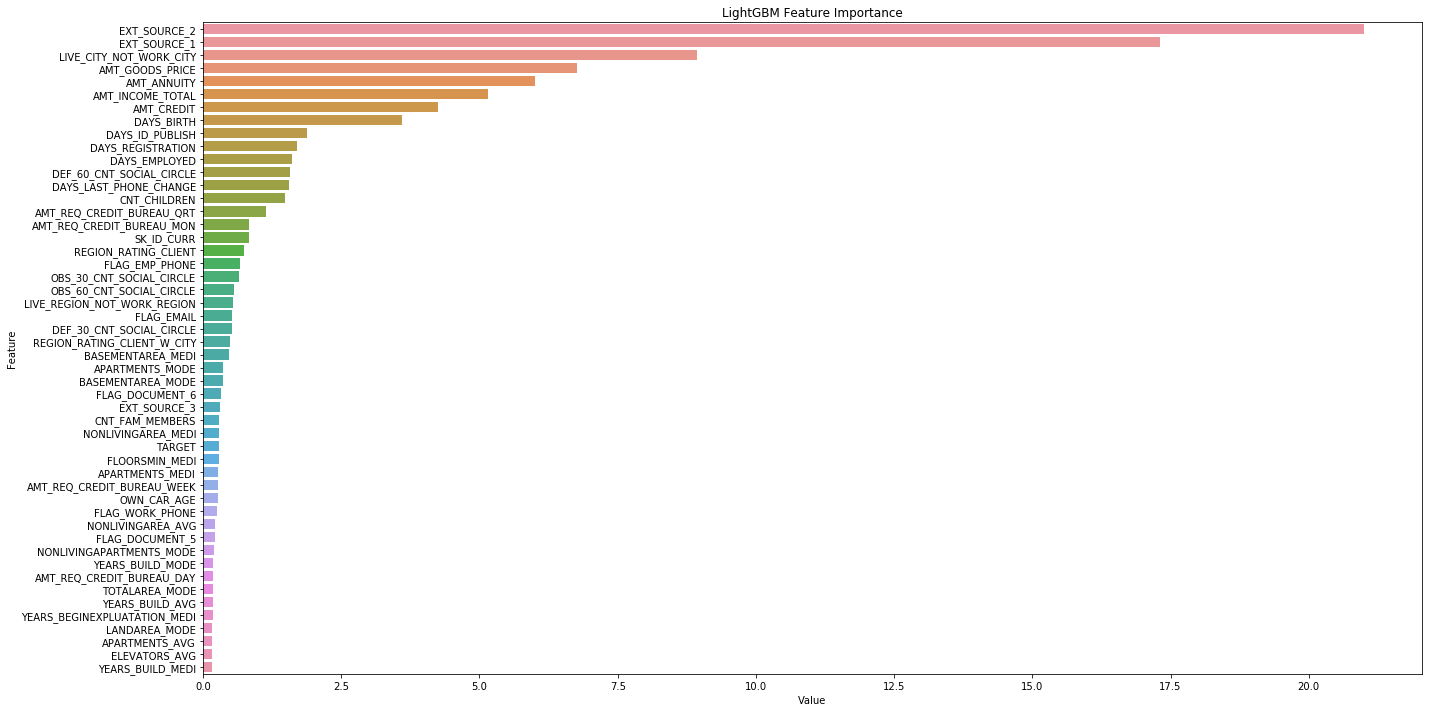

In [186]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=to_plot_lgb)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

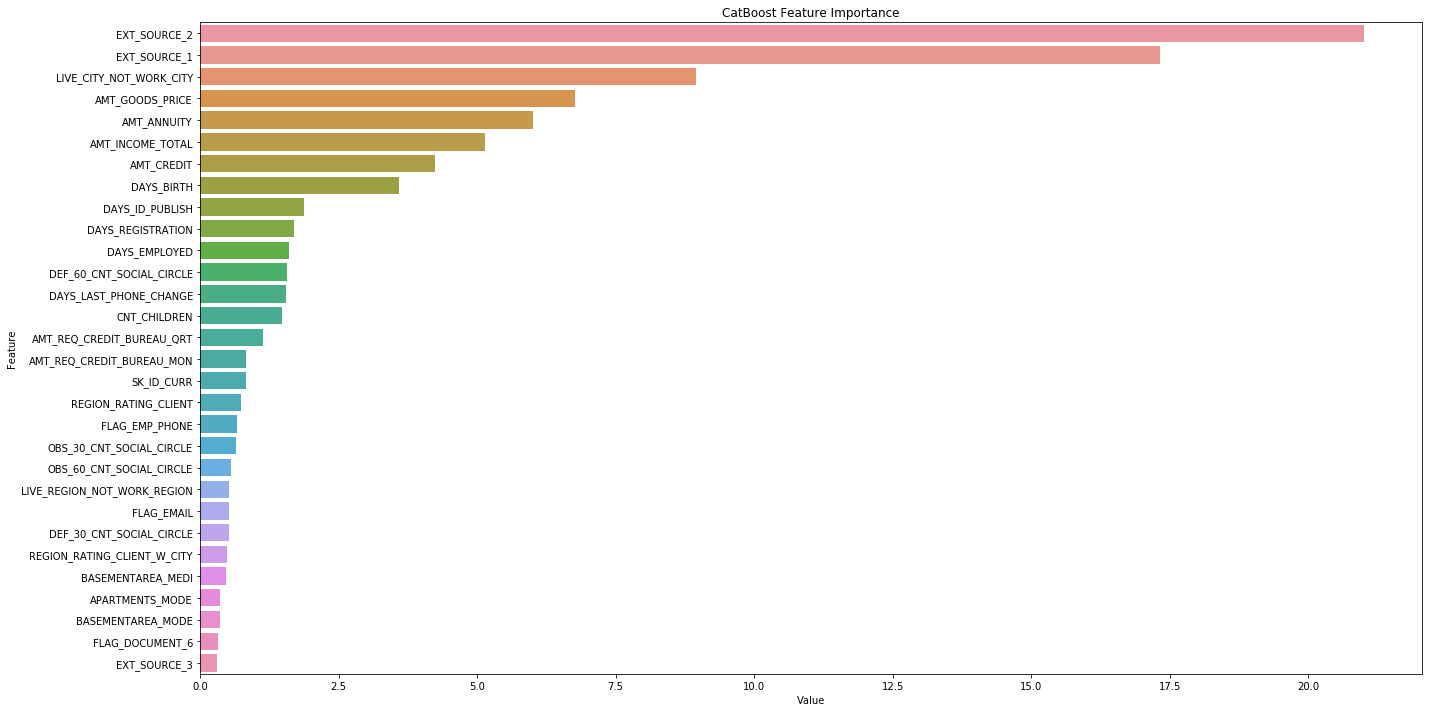

In [142]:
feature_imp = pd.DataFrame(
    sorted(zip(cat_gs.best_estimator_.feature_importances_,
               np.hstack((numeric_features, cat_features)))),
    columns=['Value','Feature'])
to_plot = feature_imp.sort_values(by="Value", ascending=False)[:30]
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=to_plot)
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

In [189]:
X_train, X_test, y_train, y_test = train_test_split(data_with_cat[to_plot[:15].Feature.values], target, test_size=0.3, random_state=0)

cat = CatBoostClassifier(silent=True, **cat_gs.best_params_,)
%time cat.fit(X_train, y_train)
average_precision_score(y_test, cat.predict_proba(X_test)[:,1])

CPU times: user 44min 44s, sys: 20 s, total: 45min 4s
Wall time: 50.4 s


0.2032569747589864

In [190]:
X_train, X_test, y_train, y_test = train_test_split(data_with_cat[to_plot_lgb[:15].Feature.values], target, test_size=0.3, random_state=0)

lgb = LGBMClassifier(**lgb2_gs.best_params_)
%time lgb.fit(X_train, y_train)
average_precision_score(y_test, lgb.predict_proba(X_test)[:,1])

CPU times: user 5min 49s, sys: 141 ms, total: 5min 49s
Wall time: 5.59 s


0.2066066843878745

__Вывод:__ Качество упало незначительно по отношению к тому количеству данных, которое было убрано из выборки, так как малозначащие признаки редко используются моделями для построений разбиений деревьев

### Бонус

__Задание 7. (Максимум 5 баллов)__

Градиентный бустинг при всех ограничениях зачастую является ультимативным решением для задач с табличными данными; соревнование от Home Credit не стало исключением. Предлагается любыми модификациями Catboost и LightGBM (другими моделями пользоваться нельзя), обработки данных и построения признаков получить высокое качество на __приватном__ наборе данных. 
Баллы можно получить за следующие значения метрики:
* 0.7955 - 1 балл
* 0.7975 - 3 баллов
* 0.80 - 5 баллов.

При сдаче этого задания необходимо приложить код, с помощью которого можно получить ту же самую метрику, что и в вашем посылке в соревновании. Если решение не будет воспроизводимым, задание засчитано не будет.

Учетная запись на kaggle: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Задание 8. (0.5 балла)__ Обратите внимание, что в соревновании метрикой выступает AUC-ROC, у нас же до этого оптимизировался AUC-PR. Можно ли утверждать, что нет необходимости в переобучении моделей для максимизации новой метрики, если мы нашли лучший алгоритм с точки зрения AUC-PR?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ